# V-PCC QoE Models

## Load the data set

In [1]:
import pandas as pd
df = pd.read_csv("ratings.csv")
df

,participant,object,distance,frame_rate,encode_method,quantization_level_index,qoe,duration,size,order
0,0,dancer,far,10,V-PCC,0,3,4451,493,22
1,0,dancer,far,10,V-PCC,1,2,4467,493,48
2,0,dancer,far,10,V-PCC,2,2,6004,493,52
3,0,dancer,far,10,V-PCC,3,3,4118,493,37
4,0,dancer,far,10,V-PCC,4,4,4370,493,11
...,...,...,...,...,...,...,...,...,...,...
12235,101,thaidancer,near,30,V-PCC,0,1,3939,491,54
12236,101,thaidancer,near,30,V-PCC,1,3,4594,491,27
12237,101,thaidancer,near,30,V-PCC,2,1,8777,491,12
12238,101,thaidancer,near,30,V-PCC,3,3,3961,491,19


## Extend features and filter results

In [2]:
import pandas as pd
from sklearn import preprocessing

# only V-PCC
df_vpcc = df.loc[df['encode_method'] == 'V-PCC'].reset_index()

# add numeric distance used in unity
distance_mapping = {'far': 8.5, 'medium': 4.5, 'near': 2.5}
df_vpcc['distance_numeric'] = df_vpcc['distance'].map(distance_mapping)

# add V-PCC parameters for used quantization levels
geometry_qp_mapping = {0: 51, 1: 36, 2: 24, 3: 20, 4: 16}
attribute_qp_mapping = {0: 51, 1: 44, 2: 32, 3: 27, 4: 22}
occupancy_precision = {0: 4, 1: 4, 2: 4, 3: 4, 4: 2}
df_vpcc['geometry_qp'] = df_vpcc['quantization_level_index'].map(geometry_qp_mapping)
df_vpcc['attribute_qp'] = df_vpcc['quantization_level_index'].map(attribute_qp_mapping)
df_vpcc['occupancy_precision'] = df_vpcc['quantization_level_index'].map(occupancy_precision)

# select features
columns = ['frame_rate', 'distance_numeric', 'geometry_qp', 'attribute_qp', 'qoe']
df_vpcc = df_vpcc[columns]

# remove outliers using boxplot method
vpcc_group_columns = ['frame_rate', 'distance_numeric', 'geometry_qp', 'attribute_qp']
configurations = df_vpcc.groupby(vpcc_group_columns)

def boxplot_outlier_filter(frame):
    """
    Outlier filter using interquantile range (filter below Q1 - 1.5 IQR and above Q3 + 1.5 IQR)

    :param frame: data frame
    :return: filtered frame
    """
    q1 = frame.quantile(0.25)["qoe"]
    q3 = frame.quantile(0.75)["qoe"]
    # interquantile range
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    filterd = (frame["qoe"] >= fence_low) & (frame["qoe"] <= fence_high)
    return frame.loc[filterd]

# for each configuration, filter outliers
df_vpcc_filtered = None
for _, frame in configurations:
    #print(boxplot_outlier_filter(frame))
    df_vpcc_filtered = pd.concat([df_vpcc_filtered, boxplot_outlier_filter(frame)], axis=0)

df_vpcc_filtered = df_vpcc_filtered.reset_index(drop=True)
groups = df_vpcc_filtered.groupby(vpcc_group_columns)

def get_train_test_fold(test_group_name, normalize=False):
    """
    Get train/test folds for leave-one-out cross-validation. 

    :param test_group_name: the group name of the test fold
    :param normalize: normalize the data with StandardScaler
    :return: tuple with data frames (train features, train labels, test features, test labels)
    """
    # remove testing group
    training_group_keys = list(groups.groups.keys())
    training_group_keys.remove(test_group_name)
    training_groups = pd.concat(list(map(groups.get_group, training_group_keys)))
   
    y_train = training_groups['qoe']
    # The features must not contain the last column
    x_train = training_groups.drop('qoe', axis=1)

    # single test sample from test group
    y_test = groups.get_group(test_group_name)['qoe'].mean()
    x_test = groups.get_group(test_group_name).head(1).iloc[:,:-1]

    if normalize:
        scaler_x = preprocessing.StandardScaler().fit(x_train)
        x_train = scaler_x.transform(x_train)
        x_test = scaler_x.transform(x_test)

    return x_train, y_train, x_test, y_test

df_vpcc_filtered

,frame_rate,distance_numeric,geometry_qp,attribute_qp,qoe
0,10,2.5,16,22,3
1,10,2.5,16,22,3
2,10,2.5,16,22,3
3,10,2.5,16,22,3
4,10,2.5,16,22,2
...,...,...,...,...,...
8965,30,8.5,51,51,4
8966,30,8.5,51,51,4
8967,30,8.5,51,51,4
8968,30,8.5,51,51,2


## Classification

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error

seed = 117

models = [
    RandomForestClassifier(n_estimators=4, random_state=seed),
    LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=seed),
    GradientBoostingClassifier(learning_rate=0.05, max_depth=3, n_estimators=50, random_state=seed),
    DecisionTreeClassifier(max_depth=10, random_state=seed),
    MLPClassifier(activation='relu', alpha=0.01, hidden_layer_sizes=[10, 20], max_iter=200, solver='adam', random_state=seed),
]

report = None
for group_name in groups.groups.keys():
    x_train, y_train, x_test, y_test = get_train_test_fold(group_name)

    for model in models:
        model.fit(x_train, y_train)

        # result of our model is the prediction of class probabilities per voting category
        class_prob_prediction = model.predict_proba(x_test)

        results = pd.DataFrame(class_prob_prediction, columns = ['prob_1','prob_2','prob_3','prob_4','prob_5'])
        results['test_configuration'] = str(group_name)
        results['model'] = model.__class__.__name__
        results['true_mos'] = y_test
        # convert class probabilities to MOS
        results['predicted_mos'] = results.apply(
            lambda row : (row['prob_1'] + 2 * row['prob_2'] + 3 * row['prob_3'] + 4 * row['prob_4'] + 5 * row['prob_5']), 
            axis = 1
        )
        results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

        report = pd.concat([report, results], axis=0, ignore_index=True)

report

,prob_1,prob_2,prob_3,prob_4,prob_5,test_configuration,model,true_mos,predicted_mos,mse
0,0.046669,0.319490,0.329050,0.222467,0.082323,"(10, 2.5, 16, 22)",RandomForestClassifier,3.034314,2.974286,0.003603
1,0.142711,0.270347,0.324494,0.222098,0.040350,"(10, 2.5, 16, 22)",LogisticRegression,3.034314,2.747028,0.082533
2,0.098555,0.327021,0.309755,0.215587,0.049082,"(10, 2.5, 16, 22)",GradientBoostingClassifier,3.034314,2.789621,0.059875
3,0.068627,0.303922,0.323529,0.220588,0.083333,"(10, 2.5, 16, 22)",DecisionTreeClassifier,3.034314,2.946078,0.007785
4,0.052139,0.298669,0.361404,0.242636,0.045152,"(10, 2.5, 16, 22)",MLPClassifier,3.034314,2.929994,0.010883
...,...,...,...,...,...,...,...,...,...,...
220,0.365139,0.382587,0.180897,0.062814,0.008563,"(30, 8.5, 51, 51)",RandomForestClassifier,2.764706,1.967075,0.636214
221,0.533699,0.245847,0.122370,0.054452,0.043632,"(30, 8.5, 51, 51)",LogisticRegression,2.764706,1.828470,0.876538
222,0.199615,0.510721,0.210742,0.050743,0.028179,"(30, 8.5, 51, 51)",GradientBoostingClassifier,2.764706,2.197151,0.322119
223,0.254902,0.421569,0.215686,0.088235,0.019608,"(30, 8.5, 51, 51)",DecisionTreeClassifier,2.764706,2.196078,0.323337


## Regression

In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import (Ridge, Lasso,LinearRegression)
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import  MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error

regressor_models = [
    KNeighborsRegressor(leaf_size=10, n_neighbors=10),
    RandomForestRegressor(random_state=seed),
    Ridge(random_state=seed),
    Lasso(random_state=seed),
    GradientBoostingRegressor(random_state=seed),
    DecisionTreeRegressor(random_state=seed),
    MLPRegressor(random_state=seed),
    LinearRegression(),
    make_pipeline(PolynomialFeatures(2), preprocessing.StandardScaler(), LinearRegression())
]

for group_name in groups.groups.keys():
    x_train, y_train, x_test, y_test = get_train_test_fold(group_name)

    for model in regressor_models:
        model.fit(x_train, y_train)

        # result is the MOS prediction
        mos_prediction = model.predict(x_test)
        
        results = pd.DataFrame(mos_prediction, columns =['predicted_mos'])
        results['test_configuration'] = str(group_name)
        results['model'] = model.__class__.__name__
        results['true_mos'] = y_test
        results['predicted_mos'] =float(mos_prediction) 
        results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

        report = pd.concat([report, results], axis=0, ignore_index=True)

report

,prob_1,prob_2,prob_3,prob_4,prob_5,test_configuration,model,true_mos,predicted_mos,mse
0,0.046669,0.319490,0.329050,0.222467,0.082323,"(10, 2.5, 16, 22)",RandomForestClassifier,3.034314,2.974286,0.003603
1,0.142711,0.270347,0.324494,0.222098,0.040350,"(10, 2.5, 16, 22)",LogisticRegression,3.034314,2.747028,0.082533
2,0.098555,0.327021,0.309755,0.215587,0.049082,"(10, 2.5, 16, 22)",GradientBoostingClassifier,3.034314,2.789621,0.059875
3,0.068627,0.303922,0.323529,0.220588,0.083333,"(10, 2.5, 16, 22)",DecisionTreeClassifier,3.034314,2.946078,0.007785
4,0.052139,0.298669,0.361404,0.242636,0.045152,"(10, 2.5, 16, 22)",MLPClassifier,3.034314,2.929994,0.010883
...,...,...,...,...,...,...,...,...,...,...
625,NaN,NaN,NaN,NaN,NaN,"(30, 8.5, 51, 51)",GradientBoostingRegressor,2.764706,2.378509,0.149148
626,NaN,NaN,NaN,NaN,NaN,"(30, 8.5, 51, 51)",DecisionTreeRegressor,2.764706,2.196078,0.323337
627,NaN,NaN,NaN,NaN,NaN,"(30, 8.5, 51, 51)",MLPRegressor,2.764706,1.911132,0.728588
628,NaN,NaN,NaN,NaN,NaN,"(30, 8.5, 51, 51)",LinearRegression,2.764706,2.206656,0.311419


## Aggregate results

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score as R2
import math

model_performance = None

for model, group_content in report.groupby('model'):
    single_model_performance = pd.DataFrame(
        data=
        [[
            model,
            R2(group_content['true_mos'], group_content['predicted_mos']),
            mean_squared_error(group_content['true_mos'], group_content['predicted_mos']),
            math.sqrt(mean_squared_error(group_content['true_mos'], group_content['predicted_mos'])),
            mean_absolute_error(group_content['true_mos'], group_content['predicted_mos'])
        ]],
        columns=
        [
            "model",
            "r2_score",
            "mse",
            "rmse",
            "mae"
        ]
    )
    model_performance = pd.concat([model_performance, single_model_performance], axis=0, ignore_index=True)

model_performance = model_performance.sort_values(["r2_score", "mse", "mae"], ascending=False).reset_index(drop=True)
model_performance

,model,r2_score,mse,rmse,mae
0,GradientBoostingRegressor,0.975424,0.017466,0.132159,0.097618
1,Pipeline,0.967718,0.022943,0.151469,0.116134
2,RandomForestRegressor,0.956492,0.030921,0.175843,0.120998
3,DecisionTreeRegressor,0.945684,0.038603,0.196476,0.142399
4,DecisionTreeClassifier,0.943957,0.039830,0.199575,0.146891
5,MLPClassifier,0.941260,0.041747,0.204320,0.158822
6,GradientBoostingClassifier,0.932368,0.048066,0.219240,0.172262
7,RandomForestClassifier,0.926514,0.052227,0.228532,0.170357
8,MLPRegressor,0.891453,0.077144,0.277749,0.205265
9,LogisticRegression,0.850324,0.106375,0.326152,0.248563


In [6]:
report.to_csv('performance_per_model.csv', index=False)
model_performance.to_csv('models_scores.csv', index=False)

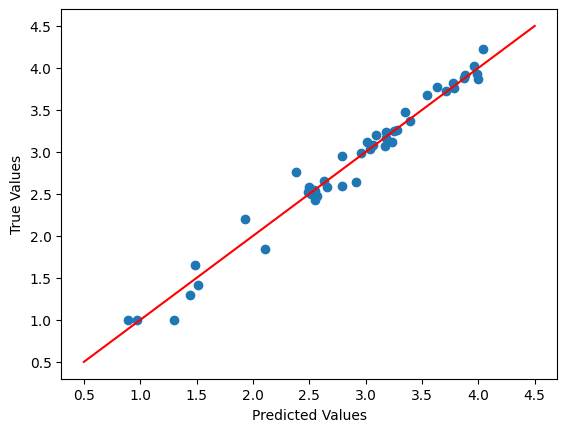

In [7]:
import matplotlib.pyplot as plt

for model, group_content in report.groupby('model'):
    if model == "GradientBoostingRegressor": 
        # Generate the scatter plot
        plt.scatter(group_content['predicted_mos'], group_content['true_mos']) 

        # Add y=x line to the plot
        plt.plot([0.5, 4.5], [0.5, 4.5], color = 'red')

        # Label the axes
        plt.xlabel('Predicted Values')
        plt.ylabel('True Values')
        
        # plt.savefig('predicted_and_true_distribution_GBR.pdf')  
        plt.show()